In [1]:
# This script generates the plasma surface, winding surface and initial filaments for the 
# force minimization study. Uses the regcoil branch and quadcoil_proto.

import os
# os.environ['XLA_FLAGS'] = '--xla_dump_to=./jax_dump'
os.environ['JAX_PLATFORMS'] = 'cpu'
import sys
import cvxpy
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from simsopt.geo import SurfaceRZFourier, plot
from simsopt.field import CurrentPotentialSolve, CurrentPotentialFourier
from simsopt.field.magneticfieldclasses import WindingSurfaceField
from simsopt.objectives import SquaredFlux
from simsopt import save, load
from functools import partial
from jax import jit, vmap
from jax.lax import while_loop
import jax
import optax
import optax.tree_utils as otu


In [2]:

# Loading QUADCOIL
quadcoil_path = '..'
sys.path.insert(1, quadcoil_path)
# The directory of the c++ code imported in self_force_operator
# must be included separately
sys.path.insert(1, quadcoil_path + '/build')
sys.path.insert(1, quadcoil_path + '/objectives')


In [30]:
from winding_surface_jax import gen_winding_surface
# from plotting_utils import plot_coil_phi_IG, plot_coil_contours
from grid_curvature_operator_jax import grid_curvature_cylindrical
from f_b_and_k_operators_jax import \
    f_B_and_current_scale, \
    K2, K_theta
from utils import avg_order_of_magnitude
from jaxopt_utils import solve_quad_unconstrained, solve_constrained, eval_quad_scaled, solve_quad_constrained
import cvxpy_utils

# Loading plasma surface and setting up parameters (replace with your own equilibrium and parameters)

In [4]:
''' --- Loading configs --- '''


# Obtaining a list of all configs
path_plasma_surface = 'plasma_surface/'
list_plasma_surface = os.listdir(path_plasma_surface)
path_vcasing = '2023-09-14.MagneticGradientScalength/vcasing/'
list_vcasing= os.listdir(path_vcasing)
path_bnorm = '2023-09-14.MagneticGradientScalength/bnorm/'
list_bnorm = os.listdir(path_bnorm)
''

''

In [5]:
# Finding a case with name containing the substring. 
# You can change current_name to something you like.
substring='li383'
print('Finding equilibrium containing:', substring)
for i_config, item in enumerate(list_plasma_surface):
    if substring in item:
        break

print(i_config)

current_plasma_surface = list_plasma_surface[i_config]
current_name = current_plasma_surface[:-4]
print('Name:', current_name)



Finding equilibrium containing: li383
33
Name: li383_1.4m_aScaling


In [6]:
''' --- Loading plasma surface --- '''


# Loads the plasma surface into plasma_surface. Replace with your own surface.
surf_dict = np.load(path_plasma_surface + current_plasma_surface, allow_pickle=True).item()
plasma_surface = SurfaceRZFourier(
    nfp=surf_dict['nfp'], 
    stellsym=surf_dict['stellsym'], 
    mpol=surf_dict['mpol'], 
    ntor=surf_dict['ntor'], 
    quadpoints_phi=surf_dict['quadpoints_phi_1fp'], 
    quadpoints_theta=jnp.linspace(0, 1, 64, endpoint=False), 
)
plasma_surface.set_dofs(surf_dict['dofs'])


''' --- Setting current --- '''


net_poloidal_current = surf_dict['net_poloidal_current']


''' --- Loading B_plasma --- '''


# Loads the normal magnetic field at the plasma surface
current_vcasing = 'vcasing_' + current_name + '.nc'
current_bnorm = 'bnorm.' + current_name
if current_bnorm in list_bnorm:
    print(current_bnorm, 'found. Loading virtual casing.')
    bnorm_data = np.loadtxt(path_bnorm+current_bnorm)
    bnorm_m = np.array(bnorm_data[:, 0], dtype=int)
    bnorm_n = np.array(bnorm_data[:, 1], dtype=int)
    bnorm_values = bnorm_data[:, 2]
    eval_grid_phi, eval_grid_theta = np.meshgrid(
        plasma_surface.quadpoints_phi, 
        plasma_surface.quadpoints_theta,
        indexing='ij'
    )
    Bnormal_plasma = np.sum(bnorm_values[:, None, None] * np.sin(
        bnorm_m[:, None, None] * eval_grid_phi[None, :, :] * np.pi * 2
        + bnorm_n[:, None, None] * eval_grid_theta[None, :, :] * np.pi * 2
    ), axis=0)
else:
    if current_vcasing in list_vcasing:
        raise TypeError('Equilibrium has no B_norm, but is not a vacuum field! '\
            'This requires virtual_casing to run, which is not functioning '\
            'properly.')
    Bnormal_plasma = np.zeros((
        len(plasma_surface.quadpoints_phi),
        len(plasma_surface.quadpoints_theta)
    ))

bnorm.li383_1.4m_aScaling found. Loading virtual casing.


In [7]:
''' --- Calculating aspect ratio --- '''

# The first constraint is a peak current density constraint that mimics the 
# coil-coil distance constraint in filament optimization. 
# Here we prescribe some arbitrary coil number by multiplying this 
# number to the aspect ratio. The more coils there are, the more accurate the 
# proxy should be
coil_per_aspect_ratio = 4.6503866245115155
mpol_cp = 4
ntor_cp = 4

plasma_aspect = plasma_surface.aspect_ratio()
total_coil_num_temp = coil_per_aspect_ratio * plasma_aspect
coils_per_half_field_period = round(total_coil_num_temp/2/plasma_surface.nfp)
total_coil_num = coils_per_half_field_period*2*plasma_surface.nfp



''' --- Calculating constraint values --- '''
# Set your min coil coil distance constraint here
coil_coil_distance = 0.5 * plasma_surface.minor_radius()
kappa_threshold = 1/(0.2 * plasma_surface.minor_radius())
coil_plasma_distance = plasma_surface.minor_radius()



# The actual proxy for that plasma surface
Given coil-coil, coil-plasma spacing and maximum curvature requirements

In [8]:
%time
# Jax winding surface generator
winding_surface_dof = gen_winding_surface(
    gamma_plasma=plasma_surface.gamma(), 
    d_expand=coil_plasma_distance, 
    nfp=plasma_surface.nfp, stellsym=plasma_surface.stellsym,
)

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 13.8 µs
weight (50, 64)
weight (64, 64)


In [9]:
surf_dict.keys()

dict_keys(['nfp', 'stellsym', 'mpol', 'ntor', 'quadpoints_phi_1fp', 'quadpoints_phi_full', 'quadpoints_theta', 'dofs', 'net_poloidal_current'])

In [10]:

winding_surface = SurfaceRZFourier(
    nfp=surf_dict['nfp'], 
    stellsym=surf_dict['stellsym'], 
    mpol=10, 
    ntor=10, 
    quadpoints_phi=surf_dict['quadpoints_phi_full'], 
    quadpoints_theta=surf_dict['quadpoints_theta'], 
)
winding_surface.set_dofs(winding_surface_dof)

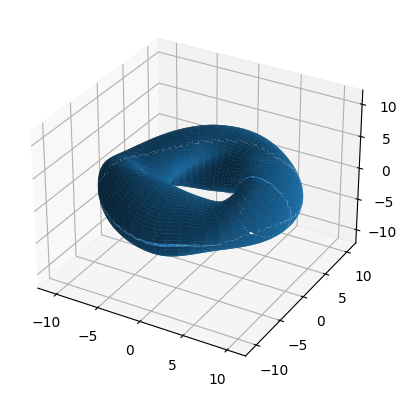

<Axes3D: >

In [11]:
winding_surface.plot()

Winding surface generated:


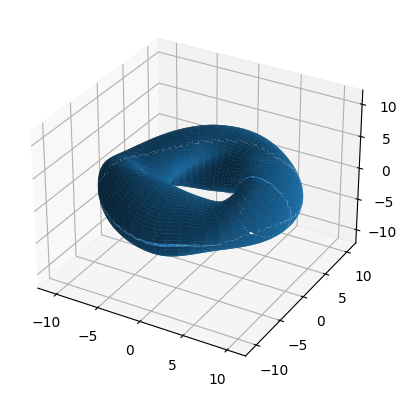

/Users/ffu/Desktop/Thesis/Codes/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


In [12]:


current_per_coil = net_poloidal_current/total_coil_num
max_K2 = (current_per_coil/coil_coil_distance)**2
KK_target = max_K2 * kappa_threshold


# There are 2 winding surface generators.
# Another one is gen_conv_winding_surface.
print('Winding surface generated:')
winding_surface.plot()


''' --- Creating simsopt regcoil objects --- '''


cp = CurrentPotentialFourier(
    winding_surface=winding_surface, 
    mpol=mpol_cp, ntor=ntor_cp,
    net_poloidal_current_amperes=net_poloidal_current,
    net_toroidal_current_amperes=0,
    quadpoints_phi=winding_surface.quadpoints_phi,
    quadpoints_theta=winding_surface.quadpoints_theta,
    stellsym=winding_surface.stellsym
)

Bnormal_plasma_flat = Bnormal_plasma.flatten()

cpst = CurrentPotentialSolve(
    cp=cp, 
    plasma_surface=plasma_surface,
    Bnormal_plasma=Bnormal_plasma_flat,
)


''' --- Preparing QUADCOIL operators --- '''


optimized_phi_mn, f_B_nescoil, _ = cpst.solve_tikhonov(lam=0)

In [55]:
A_f_B, b_f_B, c_f_B, B_normal, current_scale = f_B_and_current_scale(
    gj=cpst.gj,
    b_e=cpst.b_e,
    plasma_normal=plasma_surface.normal(),
    nfp=cp.nfp
)
A_KK_cyl, b_KK_cyl, c_KK_cyl = grid_curvature_cylindrical(
    gamma=winding_surface.gamma(),
    normal=winding_surface.normal(),
    gammadash1=winding_surface.gammadash1(),
    gammadash2=winding_surface.gammadash2(),
    gammadash1dash1=winding_surface.gammadash1dash1(),
    gammadash1dash2=winding_surface.gammadash1dash2(),
    gammadash2dash2=winding_surface.gammadash2dash2(),
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    quadpoints_phi=cp.quadpoints_phi,
    quadpoints_theta=cp.quadpoints_theta,
    nfp=cp.nfp, 
    cp_m=cp.m, 
    cp_n=cp.n,
    stellsym=cp.stellsym,
)
A_KK_cyl = A_KK_cyl[:A_KK_cyl.shape[0]//cp.nfp]
b_KK_cyl = b_KK_cyl[:b_KK_cyl.shape[0]//cp.nfp]
c_KK_cyl = c_KK_cyl[:c_KK_cyl.shape[0]//cp.nfp]
A_K2, b_K2, c_K2 = K2(
    normal=winding_surface.normal(),
    gammadash1=winding_surface.gammadash1(),
    gammadash2=winding_surface.gammadash2(),
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    quadpoints_phi=cp.quadpoints_phi,
    quadpoints_theta=cp.quadpoints_theta,
    nfp=winding_surface.nfp, 
    cp_m=cp.m, 
    cp_n=cp.n,
    stellsym=winding_surface.stellsym,
)
A_K_theta, b_K_theta, c_K_theta = K_theta(
        cp.net_poloidal_current_amperes,
        cp.quadpoints_phi,
        cp.quadpoints_theta,
        cp.nfp, cp.m, cp.n,
        cp.stellsym,
)

scale_f_B = avg_order_of_magnitude(c_f_B)
scale_KK_cyl = avg_order_of_magnitude(c_KK_cyl)
scale_K2 = avg_order_of_magnitude(c_K2)
scale_K_theta = avg_order_of_magnitude(c_K_theta)

In [56]:
A_KK_cyl.shape

(50, 50, 3, 40, 40)

# optax + augmented Lagrangian implementation

In [14]:
import jax.numpy as jnp
from jax import grad, jit, jacobian

## Solving the nescoil problem first

In [15]:
phi_scaled_init = optimized_phi_mn * current_scale

In [16]:
f_B_nescoil

29.698902118070308

In [17]:
# For debugging the outer loop in augmented lagrangian
import time
def while_loop_debug(cond_fun, body_fun, init_val):
    val = init_val
    i = 1
    print('Starting loop')
    while cond_fun(val):
        time1 = time.time()
        val = body_fun(val, None)
        time2 = time.time()
        print('Iteration', i, 'time', time2-time1, 's')
        # print('Optimality:',cond_fun(val))
        i += 1
    return val

def scan_debug(f, init, xs, length=None):
    if xs is None:
        xs = [None] * length
    carry = init
    ys = []
    i = 1
    for x in xs:
        time1 = time.time()
        carry, y = f(carry, x)
        time2 = time.time()
        print('Iteration', i, 'time', time2-time1, 's')
        i += 1
        ys.append(y)
        # print('Step result', y)
    return carry, np.stack(ys)

In [18]:
%time
phi_nescoil, state = solve_quad_unconstrained(A_f_B, b_f_B, c_f_B)

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 12.6 µs


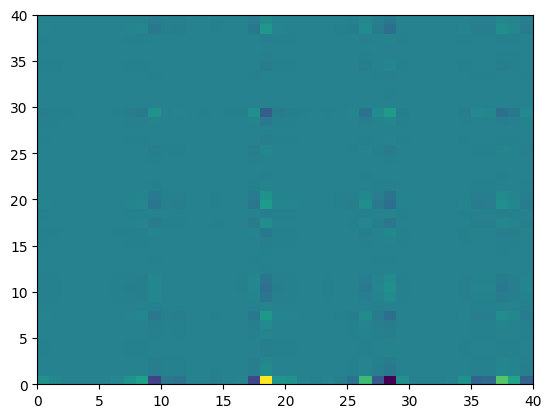

In [20]:
# Example of differentiating wrt A, b, c.
jac_unconstrained = jax.jacfwd(solve_quad_unconstrained)
a, b = jac_unconstrained(A_f_B, b_f_B, c_f_B)
plt.pcolor(a[0])

In [21]:
print('Maximum error', jnp.max(jnp.abs(phi_nescoil-phi_scaled_init)))

Maximum error 6273032.4673385015


## Answer to the no-widnowpane method with mosek

In [22]:
''' Preparing QUADCOIL constraints '''
from operator_helper import A_b_c_to_block_operator

''' Defining unknown '''
n_dof = len(cp.get_dofs())
cvxpy_X, constraints_X = cvxpy_utils.cvxpy_create_X(n_dof)
''' No windowpane '''
(
    constraints_no_windowpane, 
    K_theta_operator, 
    K_theta_scale
) = cvxpy_utils.cvxpy_no_windowpane(cp, current_scale, cvxpy_X)
''' K constraint set '''
f_B_x_operator_scaled, f_B_scale = A_b_c_to_block_operator(
    A=A_f_B, b=b_f_B, c=c_f_B, 
    current_scale=current_scale,
    normalize=True
)


Testing net current sign


In [23]:

cvxpy_windowpane = cvxpy.Problem(
    cvxpy.Minimize(cvxpy.trace(f_B_x_operator_scaled @ cvxpy_X)), 
    (
        constraints_X 
        + constraints_no_windowpane
    )
)
cvxpy_windowpane.solve(
    solver='MOSEK',
    verbose=True
)
eigenvals, eigenvecs = np.linalg.eig(cvxpy_X.value)
phi_windowpane = cvxpy_X.value[-1, :-1]/current_scale
solve_time = cvxpy_windowpane.solver_stats.solve_time
print('CVXPY Time =', solve_time, '(s)')

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Dec 23 11:20:44 AM: Your problem has 1681 variables, 1252 constraints, and 0 parameters.
(CVXPY) Dec 23 11:20:44 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 23 11:20:44 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 23 11:20:44 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 23 11:20:44 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 23 11:20:44 AM: Compiling problem (target solver=MOSEK)

## Augmented Lagrangian

In [24]:
optimized_phi_mn[2:2+2]

array([-108595.63920082,   -7707.00317331])

In [25]:
# Returns func(x) when x>=0, otherwise returns 0
# Not the proper way to implement h(x)<=0.
# def penalty(x, func):
#     condlist = [x < 0, x >= 0]
#     funclist = [lambda x: 0 * x, func]
#     return(jnp.piecewise(x, condlist, funclist))

# lin_penalty = lambda x: penalty(x, lambda x: x)
# quad_penalty = lambda x: penalty(x, lambda x: x**2)

# xTAx + bx + c leq 0
# def cons_to_penalty(A, b, c, current_scale, penalty=quad_penalty):
#     return(lambda phi_scaled: penalty(eval_quad_scaled(phi_scaled, A, b, c, current_scale)))

def h_ineq_to_h_eq(func, n_dim_x, n_cons):
    def h_eq(x_and_z):
        x = x_and_z[:n_dim_x]
        z = x_and_z[n_dim_x:n_dim_x+n_cons]
        return(func(x) + z**2)
    return(h_eq)


In [35]:
f_B = lambda x: eval_quad_scaled(x, A_f_B/scale_f_B, b_f_B/scale_f_B, c_f_B/scale_f_B, current_scale)
sign_windowpane = -jnp.sign(net_poloidal_current)
g_windowpane = lambda x: eval_quad_scaled(
    x, 
    sign_windowpane * A_K_theta/scale_K_theta,
    sign_windowpane * b_K_theta/scale_K_theta, 
    sign_windowpane * c_K_theta/scale_K_theta, 
    current_scale
)

In [36]:
# if second_order_iter:
    # # Hessian of l_o, used for second-order iteration
    # # has shape (ndof, ndof)
    # hx_k_h_eq = hx_l_o(x_k, lam_k_first_order) 
    # # Gradient of h_eq, used for second-order iteration
    # # has shape (ncons, ndof)
    # gx_k_h_eq = gx_h_eq(x_k)
    # # broadcasting hx_k_h_eq
    # # has shape (ncons, ndof, ndof)
    # hx_k_h_eq_tiled = jnp.tile(hx_k_h_eq, (gx_k_h_eq.shape[0],1,1))
    # # Constructing a matrix
    # upper = jnp.concatenate((hx_k_h_eq_tiled, gx_k_h_eq[:, :, None]), axis=2)
    # lower = jnp.concatenate((gx_k_h_eq[:, None, :], jnp.zeros((gx_k_h_eq.shape[0], 1, 1))), axis=2)
    # # has shape (ncons, ndof+1, ndof+1)
    # matrix_to_solve = jnp.concatenate((upper, lower), axis=1)
    # rhs = - jnp.concatenate((
    #     jnp.tile(gx_l_o(x_k, lam_k_first_order), (gx_k_h_eq.shape[0], 1)),
    #     h_eq(x_k)[:, None]
    # ), axis=1)
    # # Least square solving for lambda correction.
    # # has shape (ncons, ndof+1)
    # delta = lstsq_vmap(matrix_to_solve, rhs)[0]
    # delta_lam = delta[:, -1]
    # lam_k_out = lam_k_first_order + delta_lam
    # lam_k_out = lam_k_first_order + delta_lam


In [37]:
%time
result = solve_constrained(
    x_init=phi_scaled_init,
    c_init=1000,
    f_obj=f_B,
    mu_init=jnp.zeros(2500),
    g_ineq=g_windowpane,
    opt=optax.lbfgs(),
    c_growth_rate=2,
    tol_outer=1e-5,
    tol_inner=1e-5,
    max_iter_inner=500,
    max_iter_outer=20,
    # scan_mode=True,
)
print('Agumented Lagrangian result', result['x_k']/current_scale)
print('               MOSEK result', phi_windowpane)

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 13.8 µs
Agumented Lagrangian result [-7.23175628e+05 -6.18688760e+04  1.98828284e+05  5.68610111e+03
 -2.73480381e+04  3.39709196e+05 -2.14193453e+05 -1.06364563e+06
 -2.01317513e+06  2.59783871e+06  8.84914170e+04  2.62011852e+05
  2.31119619e+04 -4.55967684e+04 -2.87366742e+04  4.34620102e+04
 -9.79432719e+04  2.53136359e+06 -6.36042443e+06 -3.08165135e+05
 -4.33376338e+05  1.75026164e+05 -1.00708857e+04 -9.89665084e+04
  7.44577302e+04  6.71105583e+05 -2.69851279e+06  1.94975655e+06
  3.59613076e+06 -6.84138934e+05  4.60341701e+05  1.03057454e+04
  3.66585161e+02 -1.00049192e+05 -8.23882261e+05  1.46629915e+06
  6.81289869e+05 -2.02234145e+06 -7.05046626e+05 -7.51770044e+04]
               MOSEK result [-7.23038217e+05 -6.18175358e+04  1.98810814e+05  5.65753311e+03
 -2.73770191e+04  3.39710405e+05 -2.14204171e+05 -1.06364579e+06
 -2.01316591e+06  2.59782990e+06  8.84183621e+04  2.62012088e+05
  2.31382417e+04 -4.56019401e+04 -

In [38]:
time1 = time.time()
res_winding_surface = solve_quad_constrained(
    x_init=phi_scaled_init,
    c_init=1000,
    A_f=A_f_B/scale_f_B, b_f=b_f_B/scale_f_B, c_f=c_f_B/scale_f_B,
    mu_init=jnp.zeros(2500),
    A_ineq=sign_windowpane * A_K_theta/scale_K_theta, 
    b_ineq=sign_windowpane * b_K_theta/scale_K_theta, 
    c_ineq=sign_windowpane * c_K_theta/scale_K_theta,
    current_scale=current_scale,
)
jax.block_until_ready(res_winding_surface['x_k'])
time2 = time.time()
print('Time taken:', time2-time1, '(s)')

Time taken: 22.2998788356781 (s)


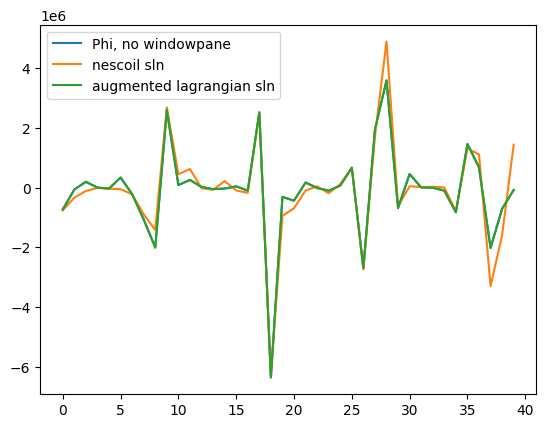

In [39]:
plt.plot(phi_windowpane, label='Phi, no windowpane')
plt.plot(optimized_phi_mn, label='nescoil sln')
plt.plot(res_winding_surface['x_k']/current_scale, label='augmented lagrangian sln')
plt.legend()

# Testing on the full problem

In [41]:
''' Preparing QUADCOIL constraints '''
from operator_helper import A_b_c_to_block_operator

''' Defining unknown '''
n_dof = len(cp.get_dofs())
cvxpy_X, constraints_X = cvxpy_utils.cvxpy_create_X(n_dof)
''' No windowpane '''
(
    constraints_no_windowpane, 
    K_theta_operator, 
    K_theta_scale
) = cvxpy_utils.cvxpy_no_windowpane(cp, current_scale, cvxpy_X)
''' K constraint set '''
AK_l2_operator_raw, AK_l2_scale = A_b_c_to_block_operator(
    A=A_K2, b=b_K2, c=c_K2, 
    current_scale=current_scale,
    normalize=True
)

AKK_operator_raw, AKK_scale = A_b_c_to_block_operator(
    A=A_KK_cyl, b=b_KK_cyl, c=c_KK_cyl, 
    current_scale=current_scale,
    normalize=True
)
# Reshaping
AK_l2_operator = AK_l2_operator_raw.reshape([-1] + list(AK_l2_operator_raw.shape[-2:]))
AKK_operator = AKK_operator_raw.reshape([-1] + list(AKK_operator_raw.shape[-2:]))

Testing net current sign


## Solving with MOSEK

In [51]:
K_dot_nabla_K_comp_scaled_flat.shape

(7500, 3, 41, 41)

In [43]:
''' Solving with MOSEK '''
constraints_K_sq_max = []
if cp.stellsym:
    loop_size_K_l2 = AK_l2_operator.shape[0]//2
else:
    loop_size_K_l2 = AK_l2_operator.shape[0]
for i in range(loop_size_K_l2):
    constraints_K_sq_max.append(cvxpy.trace(AK_l2_operator[i, :, :] @ cvxpy_X) <= max_K2/AK_l2_scale)
''' K dot nabla K L1 and Linf constraint set '''
K_dot_nabla_K_comp_scaled_flat = AKK_operator.reshape((
    -1, 3, AKK_operator.shape[-2], AKK_operator.shape[-1]
))
constraints_kdotnablak, p = cvxpy_utils.cvxpy_create_Linf_from_array(
    K_dot_nabla_K_comp_scaled_flat, 
    cvxpy_X, 
    cp.stellsym
)
constraints_kdotnablak_limit = [
    p <= KK_target/AKK_scale
]
try:
    phi_max_K_dot_nabla_K = np.load('phi_max_K_dot_nabla_K.npy')
except:
    print("CVXPY+MOSEK sln not available. Calculating from scratch.") 
    import mosek
    cvxpy_K_sq_max = cvxpy.Problem(
        cvxpy.Minimize(cvxpy.trace(f_B_x_operator_scaled @ cvxpy_X)), 
        (
            constraints_X 
            + constraints_kdotnablak
            + constraints_kdotnablak_limit
            + constraints_no_windowpane
            + constraints_K_sq_max
        )
    )
    cvxpy_K_sq_max.solve(
        solver='MOSEK',
        verbose=True
    )
    eigenvals, eigenvecs = np.linalg.eig(cvxpy_X.value)
    phi_max_K_dot_nabla_K = cvxpy_X.value[-1, :-1]/current_scale
    solve_time = cvxpy_K_sq_max.solver_stats.solve_time
    np.save('phi_max_K_dot_nabla_K.npy', phi_max_K_dot_nabla_K)
    print('CVXPY Time =', solve_time, '(s)')

CVXPY+MOSEK sln not available. Calculating from scratch.
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Dec 23 11:31:47 AM: Your problem has 1682 variables, 24999 constraints, and 0 parameters.
(CVXPY) Dec 23 11:31:49 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 23 11:31:49 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 23 11:31:49 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 23 11:31:49 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) D

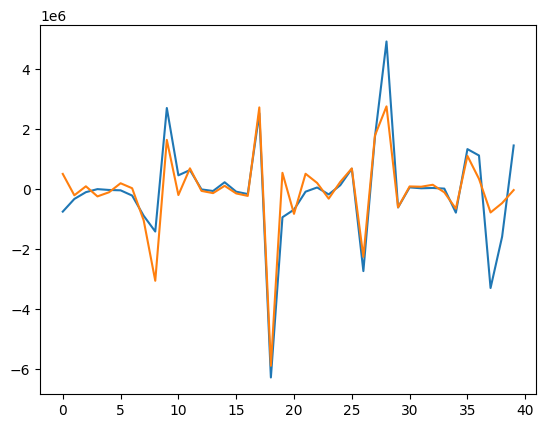

In [47]:
plt.plot(optimized_phi_mn)
plt.plot(phi_max_K_dot_nabla_K)

## Solving with Augmented lagrangian

(50, 50, 40, 40)
(50, 50, 40)
(50, 50)
(150, 50, 3, 40, 40)
(150, 50, 3, 40)
(150, 50, 3)


In [75]:
# Flatten all operators and taking stellarator symmetry into account
A_K2_obj = A_K2.reshape((-1, n_dof, n_dof))
b_K2_obj = b_K2.reshape((-1, n_dof))
c_K2_obj = c_K2.flatten()
A_KK_cyl_obj = A_KK_cyl.reshape((-1, 3, n_dof, n_dof))
b_KK_cyl_obj = b_KK_cyl.reshape((-1, 3, n_dof))
c_KK_cyl_obj = c_KK_cyl.reshape((-1, 3))
if cp.stellsym:
    loop_size_K_l2 = AK_l2_operator.shape[0]//2
else:
    loop_size_K_l2 = AK_l2_operator.shape[0]
A_K2_obj = A_K2_obj[:loop_size_K_l2]
b_K2_obj = b_K2_obj[:loop_size_K_l2]
c_K2_obj = c_K2_obj[:loop_size_K_l2]
A_KK_cyl_obj = A_KK_cyl_obj[:loop_size_K_l2].reshape((-1, n_dof, n_dof))
b_KK_cyl_obj = b_KK_cyl_obj[:loop_size_K_l2].reshape((-1, n_dof))
c_KK_cyl_obj = c_KK_cyl_obj[:loop_size_K_l2].reshape((-1))
A_K_theta_obj = A_K_theta[:loop_size_K_l2]
b_K_theta_obj = b_K_theta[:loop_size_K_l2]
c_K_theta_obj = c_K_theta[:loop_size_K_l2]

In [77]:
# |(A@phi)@phi + b@phi + c| <= a
# is equivalent to
#  (A@phi)@phi + b@phi + c <= a
# -(A@phi)@phi - b@phi - c <= a
#  (A@phi)@phi + b@phi + c - a <= 0
# -(A@phi)@phi - b@phi - c - a <= 0
print(A_K2.shape, A_K2_obj.shape)
print(b_K2.shape, b_K2_obj.shape)
print(c_K2.shape, c_K2_obj.shape)
print(A_KK_cyl.shape, A_KK_cyl_obj.shape)
print(b_KK_cyl.shape, b_KK_cyl_obj.shape)
print(c_KK_cyl.shape, c_KK_cyl_obj.shape)
print(A_K_theta_obj.shape)
print(b_K_theta_obj.shape)
print(c_K_theta_obj.shape)

(50, 50, 40, 40) (1250, 40, 40)
(50, 50, 40) (1250, 40)
(50, 50) (1250,)
(50, 50, 3, 40, 40) (3750, 40, 40)
(50, 50, 3, 40) (3750, 40)
(50, 50, 3) (3750,)
(1250, 40, 40)
(1250, 40)
(1250,)


In [74]:
A_K_theta.shape

(2500, 40, 40)

In [79]:
''' Combining all constraints into 3 big arrays '''
if cp.stellsym:
    loop_size_K_l2 = AK_l2_operator.shape[0]//2
else:
    loop_size_K_l2 = AK_l2_operator.shape[0]

A_total = jnp.concatenate([
    A_K2_obj/scale_K2, 
    -A_K2_obj/scale_K2, 
    A_KK_cyl_obj/scale_KK_cyl, 
    -A_KK_cyl_obj/scale_KK_cyl, 
    sign_windowpane * A_K_theta_obj/scale_K_theta
], axis=0)

b_total = jnp.concatenate([
    b_K2_obj/scale_K2, 
    -b_K2_obj/scale_K2, 
    b_KK_cyl_obj/scale_KK_cyl, 
    -b_KK_cyl_obj/scale_KK_cyl, 
    sign_windowpane * b_K_theta_obj/scale_K_theta
], axis=0)

c_total = jnp.concatenate([
    c_K2_obj/scale_K2 - max_K2/scale_K2, 
    -c_K2_obj/scale_K2 - max_K2/scale_K2, 
    c_KK_cyl_obj/scale_KK_cyl - KK_target/scale_KK_cyl, 
    -c_KK_cyl_obj/scale_KK_cyl - KK_target/scale_KK_cyl, 
    sign_windowpane * c_K_theta_obj/scale_K_theta
], axis=0)

In [83]:
phi_scaled_init

(11250, 40, 40)
(11250, 40)
(11250,)


In [92]:
time1 = time.time()
res_quadcoil = solve_quad_constrained(
    x_init=phi_scaled_init,
    c_init=1000,
    A_f=A_f_B/scale_f_B, 
    b_f=b_f_B/scale_f_B, 
    c_f=c_f_B/scale_f_B,
    mu_init=jnp.zeros_like(c_total),
    A_ineq=A_total, 
    b_ineq=b_total, 
    c_ineq=c_total,
    current_scale=current_scale,
    max_iter_inner=1500,
    max_iter_outer=15,
)
jax.block_until_ready(res_quadcoil['x_k'])
time2 = time.time()
print('Time taken:', time2-time1, '(s)')

Time taken: 567.855889081955 (s)


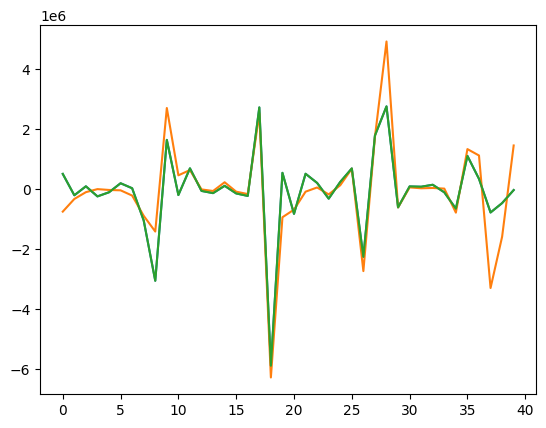

In [90]:
plt.plot(res_quadcoil['x_k']/current_scale)
plt.plot(optimized_phi_mn)
plt.plot(phi_max_K_dot_nabla_K)

In [ ]:
''' --- Calculating normalized field error of the solution --- '''

cp_temp = CurrentPotentialFourier(
    winding_surface=winding_surface, 
    mpol=mpol_cp, ntor=ntor_cp,
    net_poloidal_current_amperes=net_poloidal_current,
    net_toroidal_current_amperes=0,
    quadpoints_phi=winding_surface.quadpoints_phi,
    quadpoints_theta=winding_surface.quadpoints_theta,
    stellsym=winding_surface.stellsym
)
cp_temp.set_dofs(quadcoil_phi)
Bfield = WindingSurfaceField(cp_temp)
tgt_shape = (
    len(plasma_surface.quadpoints_phi), 
    len(plasma_surface.quadpoints_theta)
)
Jf_actual = SquaredFlux(
    plasma_surface, 
    Bfield, 
    target=Bnormal_plasma_flat.reshape(tgt_shape),
    definition='quadratic flux'
)

Jf_norm = SquaredFlux(
    plasma_surface, 
    Bfield, 
    target=Bnormal_plasma_flat.reshape(tgt_shape),
    definition='normalized'
)
# Returns the predicted field error, the predicted normalized field error, 
# and the sheet current these errors are measured from
return(Jf_actual.J(), Jf_norm.J(), cp_temp)

Winding surface generated:


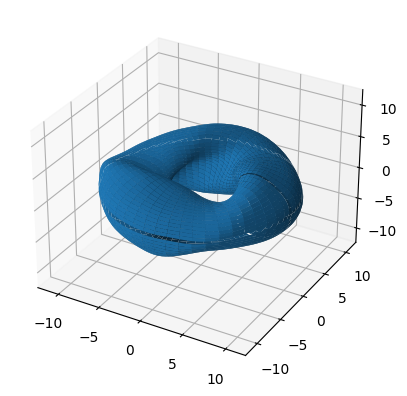

In [ ]:
field_error, field_error_norm, cp_quadcoil = field_errors_under_curvature_constraints(plasma_surface, Bnormal_plasma, net_poloidal_current, total_coil_num, coil_plasma_distance, coil_coil_distance, kappa_threshold)
print('Filament field error will be ')

<Axes3D: >

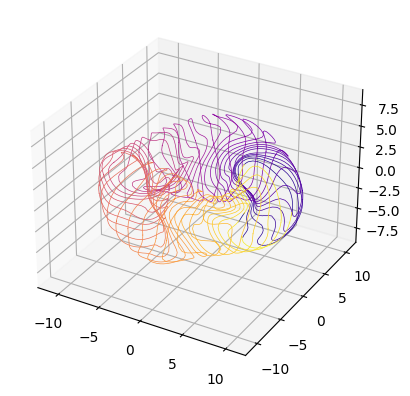

In [8]:
plot_coil_phi_IG(cp_quadcoil)

numCoils 18
contour_zeta 18
contour_theta 18


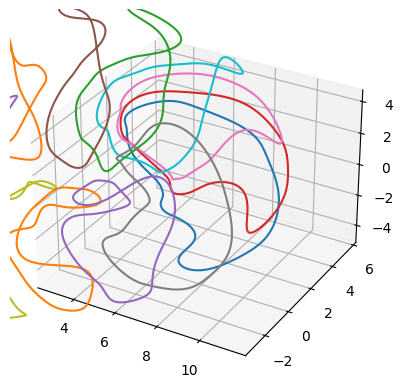

<Axes3D: >

In [10]:
coils = cut_coil_from_cp(
    cp_quadcoil, coilsPerHalfPeriod=coils_per_half_field_period, thetaShift=0
)
plot(coils)